In [5]:
import pandas as pd
from ta.momentum import RSIIndicator
from ta.trend import MACD
import numpy as np

# Load the dataset
data = pd.read_csv("C:\\Deep RL Stock Trading Project\\Dataset\\ADANIPORTS.csv")

# Parse the Date column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select relevant columns for DRL
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Add technical indicators
data['RSI'] = RSIIndicator(data['Close']).rsi()
macd = MACD(data['Close'])
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

# Normalize the data
data = (data - data.mean()) / data.std()
data.dropna(inplace=True)

print(data.head())


                Open      High       Low     Close    Volume       RSI  \
Date                                                                     
2008-01-15  3.619652  3.660759  3.702197  3.653786 -0.517533 -0.916557   
2008-01-16  3.621718  3.586748  3.511130  3.554587 -0.521018 -1.066997   
2008-01-17  3.642377  3.533882  3.569430  3.505376 -0.638016 -1.141661   
2008-01-18  3.435787  3.627026  3.378098  3.369139 -0.554967 -1.343857   
2008-01-21  3.358315  3.289695  2.428324  2.490850 -0.527734 -2.229261   

                MACD  MACD_signal  
Date                               
2008-01-15  0.490117     2.344397  
2008-01-16  0.004252     1.877372  
2008-01-17 -0.415318     1.414023  
2008-01-18 -0.847617     0.950894  
2008-01-21 -1.877150     0.360215  


In [10]:
import gym
from gym import spaces

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        
        # Action space: Buy, Sell, Hold
        self.action_space = spaces.Discrete(3)
        
        # Observation space: Stock data + balance + holdings
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(data.shape[1] + 2,), dtype=np.float32
        )
        
        # Initialize variables
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_assets = self.initial_balance

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_assets = self.initial_balance
        return self._get_observation()

    def _get_observation(self):
        obs = self.data.iloc[self.current_step].values
        return np.append(obs, [self.balance, self.shares_held])

    def step(self, action):
        # Current price
        current_price = self.data.iloc[self.current_step]['Close']
        reward = 0
        
        # Execute action
        if action == 0:  # Buy
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price
        elif action == 1:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price
        
        # Update total assets and calculate reward
        self.total_assets = self.balance + (self.shares_held * current_price)
        reward = self.total_assets - self.initial_balance
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        
        return self._get_observation(), reward, done, {}

    def render(self, mode='human'):
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Total assets: {self.total_assets}')


In [13]:
import random

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        
        # Action space: Buy, Sell, Hold
        self.action_space = spaces.Discrete(3)
        
        # Observation space: Stock data + balance + holdings
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(data.shape[1] + 2,), dtype=np.float32
        )
        
        # Initialize variables
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_assets = self.initial_balance

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_assets = self.initial_balance
        return self._get_observation()

    def _get_observation(self):
        obs = self.data.iloc[self.current_step].values
        return np.append(obs, [self.balance, self.shares_held])

    def step(self, action):
        # Current price
        current_price = self.data.iloc[self.current_step]['Close']
        reward = 0
        
        # Execute action
        if action == 0:  # Buy
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price
        elif action == 1:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price
        
        # Update total assets and calculate reward
        self.total_assets = self.balance + (self.shares_held * current_price)
        reward = self.total_assets - self.initial_balance
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        
        return self._get_observation(), reward, done, {}

    def render(self, mode='human'):
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Total assets: {self.total_assets}')
    
    def seed(self, seed=None):
        # Set random seed for reproducibility
        random.seed(seed)
        np.random.seed(seed)


In [14]:
# Create environment
env = StockTradingEnv(data)

# Vectorized environment for parallel training (optional)
vec_env = make_vec_env(lambda: env, n_envs=1)

# Train the PPO model
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=10000)

# Save the model
model.save("ppo_stock_trading")


c:\Users\Tanvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 939  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.29e+03    |
|    ep_rew_mean          | -1.06e+05   |
| time/                   |             |
|    fps                  | 541         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011040771 |
|    clip_fraction        | 0.00586     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.03e+05    |
|    n_updates            | 10          |
|    policy_gradi

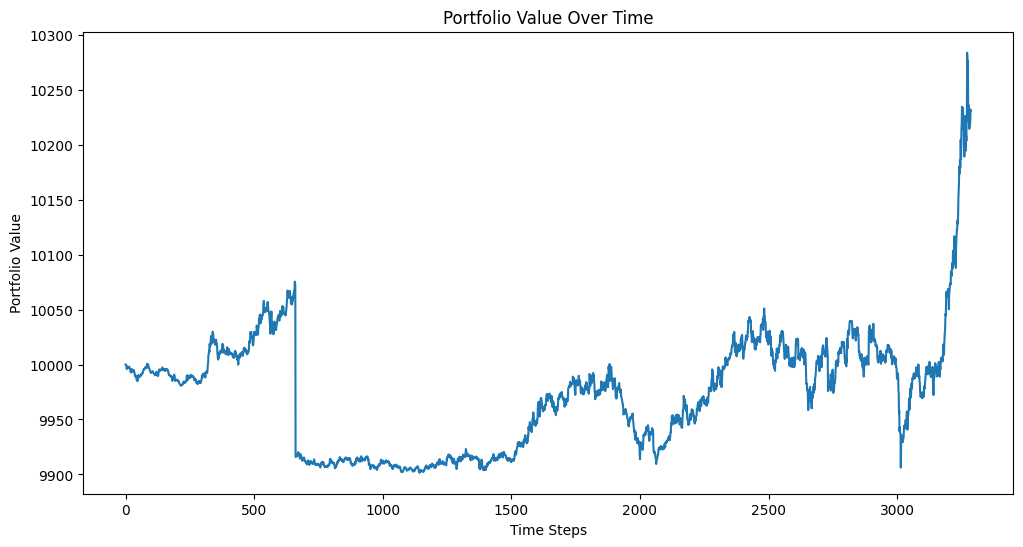

In [15]:
# Load the trained model
model = PPO.load("ppo_stock_trading")

# Create the environment for testing
env = StockTradingEnv(data)

# Reset the environment
obs = env.reset()

# Store portfolio values to visualize performance over time
portfolio_values = []

# Run the agent for a set number of steps
for _ in range(len(data) - 1):
    action, _states = model.predict(obs)  # Get action (Buy/Sell/Hold)
    obs, reward, done, info = env.step(action)  # Take the action
    portfolio_values.append(env.total_assets)  # Track portfolio value
    
    if done:
        break

# Plot the portfolio value over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.show()


Final Buy and Hold value: 5470.323437852688


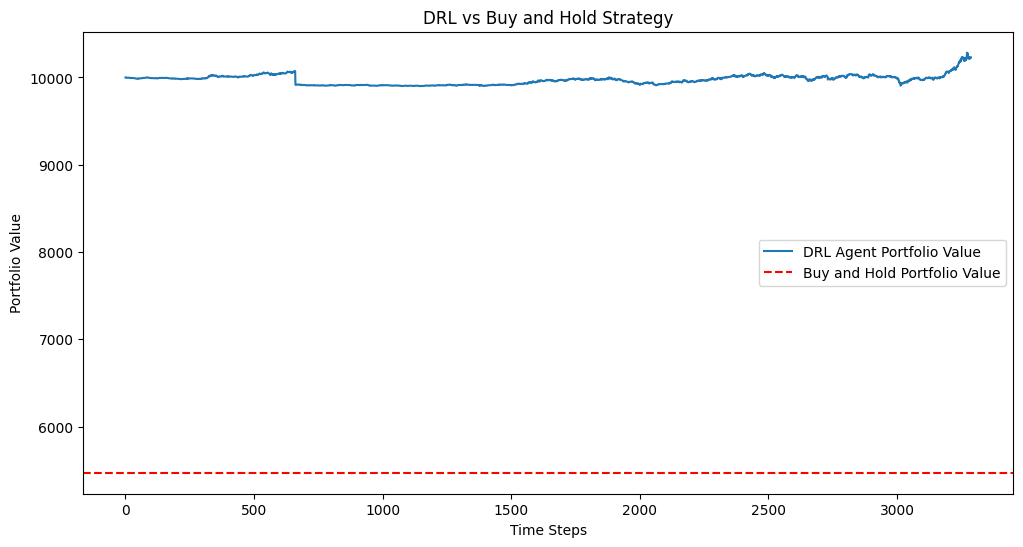

In [16]:
# Calculate the Buy and Hold strategy performance
initial_balance = 10000
buy_and_hold_value = initial_balance

# Get the initial stock price (for buying at the start)
initial_price = data.iloc[0]['Close']

# Buy at the start and hold until the end
final_price = data.iloc[-1]['Close']
buy_and_hold_value *= (final_price / initial_price)

print(f"Final Buy and Hold value: {buy_and_hold_value}")

# Plot the Buy and Hold strategy vs model performance
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="DRL Agent Portfolio Value")
plt.axhline(y=buy_and_hold_value, color='r', linestyle='--', label="Buy and Hold Portfolio Value")
plt.title("DRL vs Buy and Hold Strategy")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


In [17]:
# Save the model
model.save("ppo_stock_trading_final")

# Optionally, save the environment and other objects
import pickle
with open("stock_trading_env.pkl", "wb") as f:
    pickle.dump(env, f)
